In [1]:
import warnings

warnings.filterwarnings("ignore")
import utils

from climada.entity import ImpactFuncSet, ImpfTropCyclone
from climada.engine import ImpactCalc
from climada.util.api_client import Client
from climada.util.constants import CMAP_IMPACT
from climada.util.plot import plot_from_gdf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

client = Client()
haz_tc_haiti = client.get_hazard(
    "tropical_cyclone",
    properties={
        "country_name": "Haiti",
        "climate_scenario": "historical",
        "nb_synth_tracks": "10",
    },
)

# prepare exposure
exposure = client.get_litpop(country="Haiti")

# prepare impact function
impf_tc = ImpfTropCyclone.from_emanuel_usa()
impf_set = ImpactFuncSet([impf_tc])

In [2]:
# compute impact

impact = ImpactCalc(exposure, impf_set, haz_tc_haiti).impact(save_mat=True)

test_return_periods = np.geomspace(.01, 500, 100)

# local exceedance impact
local_exceedance_impact, label, title = impact.local_exceedance_impact(
    return_periods=test_return_periods, method="extrapolate_constant", #method="extrapolate" method="extrapolate_constant"
)

In [3]:
title(["test"])

['Return Period: test years']

In [4]:
from return_period_maps import ReturnPeriodMap, ExceedanceCurve
rp_map = ReturnPeriodMap.from_climada_local_exceedance_impact(local_exceedance_impact)

<Axes: >

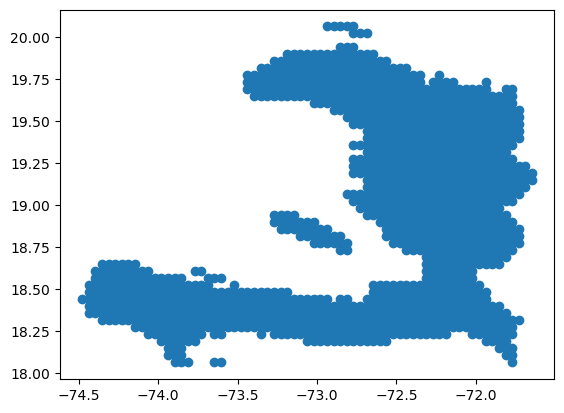

In [5]:
rp_map.geometry.plot()

In [6]:
# cf_test = 1
# for cfactor in [-.3, -.3 , -.1, 0., 0., 0., 0.5, 0.5, 0.95, 0.95]:
#     rp_map_half =  rp_map.coarsen(scale_factor=1.5, kwargs_combine_exceedance_curves={
#         "coincidence_fraction": cf_test, "n_samples": 10000, "correlation_factor": cfactor
#     })
#     print("AAI coarsened", rp_map_half.compute_aai_aggregated(coincidence_fraction=cf_test)/1_000_000)

# print("AAI original", rp_map.compute_aai_aggregated(coincidence_fraction=cf_test)/1_000_000)

In [7]:
"""
cfraction = 0.001

AAI coarsened 188.58142271283447
AAI coarsened 168.67296634945293
AAI coarsened 238.69089856164635
AAI coarsened 191.1809631184571
AAI coarsened 224.90404980173767
AAI coarsened 157.14631712428942
AAI coarsened 203.65854461349062
AAI coarsened 151.6436576959342
AAI coarsened 155.17051241723615
AAI coarsened 165.41125160218897

AAI original 192.99767390268812
"""

"""
cfraction = 1

AAI coarsened 186.19364150788448
AAI coarsened 195.28391101772823
AAI coarsened 201.4644011973284
AAI coarsened 189.23778902017452
AAI coarsened 194.21403059159664
AAI coarsened 193.32168863028068
AAI coarsened 194.46539212797484
AAI coarsened 184.82879083660058
AAI coarsened 198.44643713108903
AAI coarsened 188.63992229600277
AAI original 191.26191196170652
""";

## RP map plots before and after changing resolution

In [9]:
print("AAI before", rp_map.compute_aai_aggregated()/1_000_000)

rp_map_half_short =  rp_map.coarsen(scale_factor=2, coincidence_fraction=0.01, n_samples=20000,correlation_factor=0,)
print("AAI after", rp_map_half_short.compute_aai_aggregated()/1_000_000)

rp_map_half =  rp_map.coarsen(scale_factor=2, coincidence_fraction=1, n_samples=20000, correlation_factor=0,)
print("AAI after", rp_map_half.compute_aai_aggregated()/1_000_000)

AAI before 192.99942764214725
AAI after 169.03943246463356
AAI after 192.80613430776518


Upper panel: direct computation from impact object

Middle panel: after transforming to RPMap instance and back

Lower panel: after coarsening RPMap per year

Lower panel: after coarsening RPMap per 0.01 year


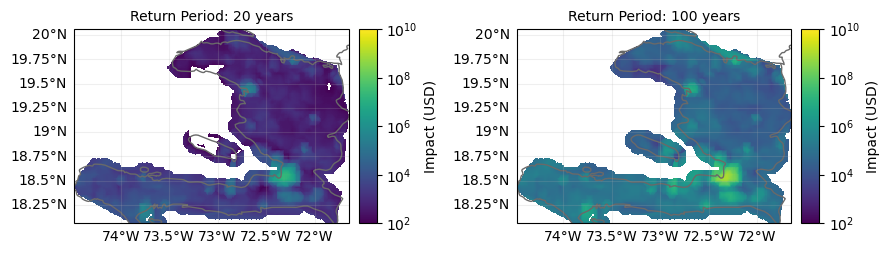

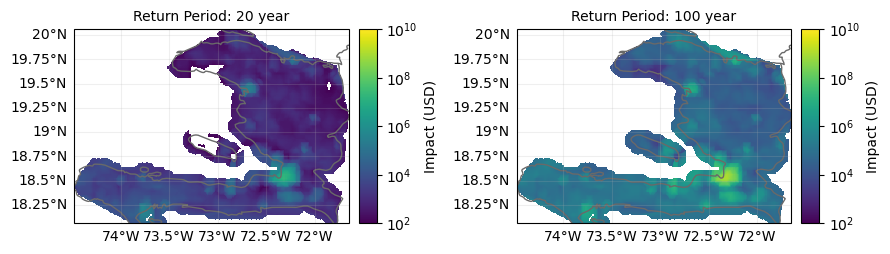

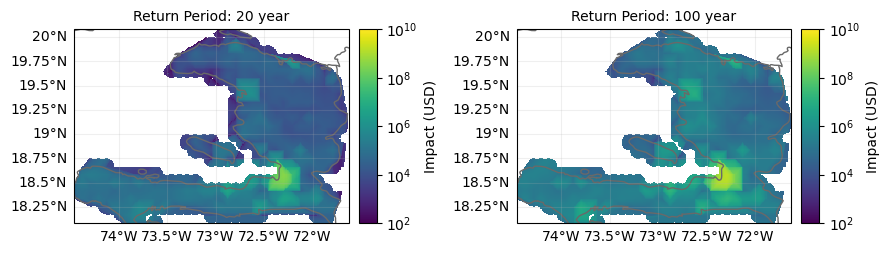

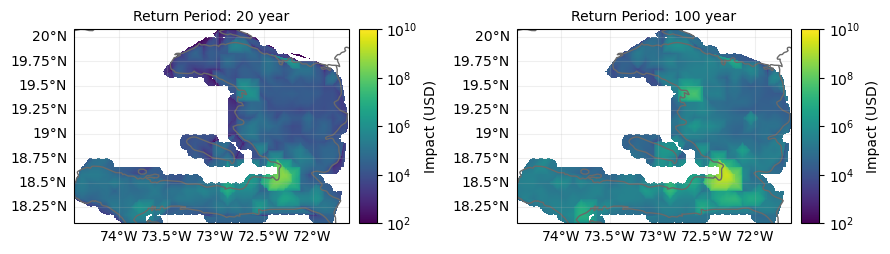

In [11]:
test_rps = [20, 100] #[19.4104162,100]
vmin, vmax = 1e2, 1e10

print("Upper panel: direct computation from impact object\n\n" \
    "Middle panel: after transforming to RPMap instance and back\n\n" \
    "Lower panel: after coarsening RPMap per year\n\n" \
    "Lower panel: after coarsening RPMap per 0.01 year")

gdf0, title, label = impact.local_exceedance_impact(
    return_periods=test_rps, method="extrapolate_constant"
)
plot_from_gdf(gdf0, title, label, norm=LogNorm(vmin=vmin, vmax=vmax));


gdf, title, label = rp_map.get_local_exceedance_values(test_rps, method="extrapolate_constant")
plot_from_gdf(gdf, title, label, norm=LogNorm(vmin=vmin, vmax=vmax));

gdf_half, title, label = rp_map_half.get_local_exceedance_values(test_rps, method="extrapolate_constant")
plot_from_gdf(gdf_half, title, label, norm=LogNorm(vmin=vmin, vmax=vmax));

gdf_half_short, title, label = rp_map_half_short.get_local_exceedance_values(test_rps, method="extrapolate_constant")
plot_from_gdf(gdf_half_short, title, label, norm=LogNorm(vmin=vmin, vmax=vmax));


In [15]:
gdf_half

,geometry,20,100
3,POINT (-74.45833 18.33333),2430.112230,51188.964293
4,POINT (-74.45833 18.41667),59140.468671,173309.196353
5,POINT (-74.45833 18.50000),47633.351814,299475.995368
28,POINT (-74.37500 18.33333),92553.284842,344430.133226
29,POINT (-74.37500 18.41667),100761.038129,246630.367267
...,...,...,...
839,POINT (-71.70833 19.25000),2338.693581,19189.327498
841,POINT (-71.70833 19.41667),3592.460630,20507.380364
842,POINT (-71.70833 19.50000),14403.165134,167609.779403
843,POINT (-71.70833 19.58333),6166.939485,341140.459797


In [13]:
gdf_half_short

,geometry,20,100
3,POINT (-74.45833 18.33333),3399.265085,66096.900212
4,POINT (-74.45833 18.41667),87968.645033,192242.194973
5,POINT (-74.45833 18.50000),30862.360638,249400.657419
28,POINT (-74.37500 18.33333),52776.116250,341747.878703
29,POINT (-74.37500 18.41667),149617.187296,254408.166145
...,...,...,...
839,POINT (-71.70833 19.25000),3542.895978,20694.659204
841,POINT (-71.70833 19.41667),2601.712099,16336.857457
842,POINT (-71.70833 19.50000),19574.397125,352844.740782
843,POINT (-71.70833 19.58333),6455.760897,124118.380520


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Return Period (year)', ylabel='Exceedance value (USD)'>)

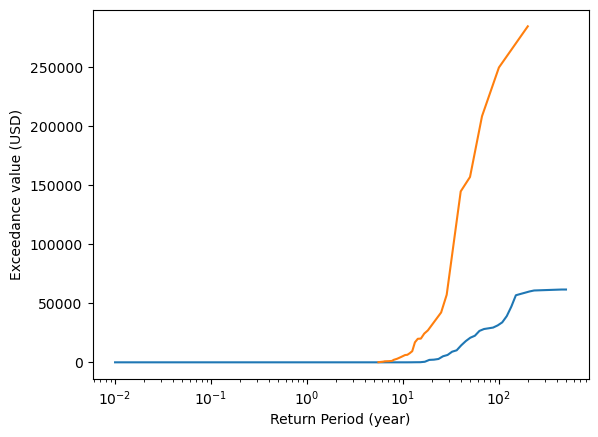

In [19]:
index = 2
fig, ax = rp_map.exceedance_curves[index].plot_exceedance_values_curve()
rp_map_half_short.exceedance_curves[index].plot_exceedance_values_curve(axis=ax)